## Imports and reading dataset


!pip install transformers torch

!pip install seqeval

!pip install git+https://www.github.com/keras-team/keras-contrib.git

!pip install googletrans==4.0.0-rc1
!pip install --upgrade googletrans==4.0.0-rc1

In [5]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import re

import nltk
nltk.download('punkt')

import torch
from transformers import AutoTokenizer, AutoModel

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# keras
from keras.models import Sequential, load_model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

import pickle

from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv("datasets\merged_df.csv").tail(500)
df

,text,emotion
1615,kefaya awe mara wa7da,neutral
1616,ana enbhart w etfg2t awii b7aga zay kda,surprise
1617,el 7war da kol mftkro o3od ad7ak awiii,happiness
1618,mt3sbnesh mashy!,angry
1619,gatko nela shba kan kwayez b2a w7sh awii,angry
...,...,...
2110,eh el araf da ana mt3sab,angry
2111,tab law omt w gbthalk..,neutral
2112,ana msh msda2 ana masdoom,surprise
2113,eh el mofg2at el 8areba de,surprise


neutral: Count = 204 -----------------> Percentage = 40.80%
happiness: Count = 109 -----------------> Percentage = 21.80%
angry: Count = 62 -----------------> Percentage = 12.40%
sadness: Count = 48 -----------------> Percentage = 9.60%
surprise: Count = 39 -----------------> Percentage = 7.80%
fear: Count = 38 -----------------> Percentage = 7.60%


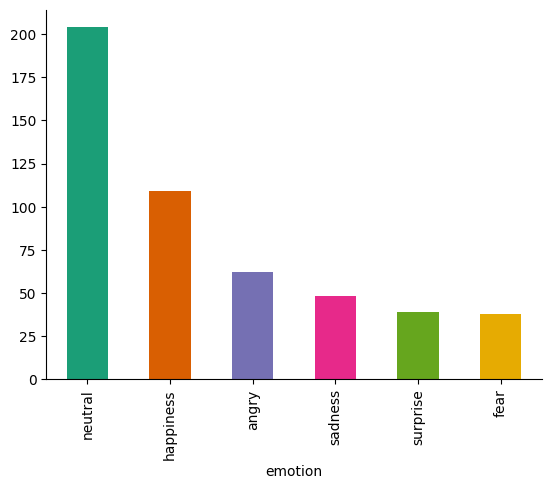

In [7]:
df.groupby('emotion').size().sort_values(ascending=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)

# Calculating and printing percentages in descending order
emotion_counts = df['emotion'].value_counts()
total_samples = len(df)

for emotion, count in emotion_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{emotion}: Count = {count} -----------------> Percentage = {percentage:.2f}%")

## a) Step 1 : Preprocessing

+ Remove URLs
+ Remove user mentions
+ Remove hashtags
+ Remove punctuation
+ Tokenize the text
+ Convert to lower case
+ Join the tokens back into a clean text

<!-- + Remove repeated letters -->




In [106]:
def clean_text(text):
    # Remove URLs https://www.example.com/
    text = re.sub(r'http\S+', '', text)

    # Remove user mentions @mohamed_samy
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Remove hashtags #free_palestine
    text = re.sub(r'#', '', text)

    # Remove punctuation period, comma, apostrophe, quotation, question, exclamation, brackets, braces, parenthesis, dash, hyphen, ellipsis, colon, semicolon
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove repeated letters
    # tokens = [re.sub(r'(.)\1+', r'\1', word) for word in tokens]

    # Convert to lower case
    tokens = [word.lower() for word in tokens]

    # Join the tokens back into a clean text
    clean_text = ' '.join(tokens)

    return clean_text

df['clean_text'] = df['text'].apply(clean_text)
df

,text,emotion,clean_text
1615,kefaya awe mara wa7da,neutral,kefaya awe mara wa7da
1616,ana enbhart w etfg2t awii b7aga zay kda,surprise,ana enbhart w etfg2t awii b7aga zay kda
1617,el 7war da kol mftkro o3od ad7ak awiii,happiness,el 7war da kol mftkro o3od ad7ak awiii
1618,mt3sbnesh mashy!,angry,mt3sbnesh mashy
1619,gatko nela shba kan kwayez b2a w7sh awii,angry,gatko nela shba kan kwayez b2a w7sh awii
...,...,...,...
2110,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab
2111,tab law omt w gbthalk..,neutral,tab law omt w gbthalk
2112,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom
2113,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de


In [4]:
test_clean = clean_text("@Mo_Hussein eh elgamal da alf mabrook!!")
test_clean

NameError: name 'clean_text' is not defined

## Translate tweets to Arabic Language

https://github.com/ssut/py-googletrans/issues/257

In [2]:
from googletrans import Translator

def translate_to_arabic(text):
    translator = Translator()
    translation = translator.translate(text, dest='ar')
    return translation.text

In [3]:
test_statment = translate_to_arabic("@Mo_Hussein eh elgamal da alf mabrook")
print(test_statment)

@محسين إيه الجمال دى ألف مبروك!!


In [ ]:
df['arabic_text'] = df['clean_text'].apply(translate_to_arabic)
df

AttributeError: 'Translator' object has no attribute 'raise_Exception'

## b) Step 2: The usage of Word Embedding
+ AraBERT


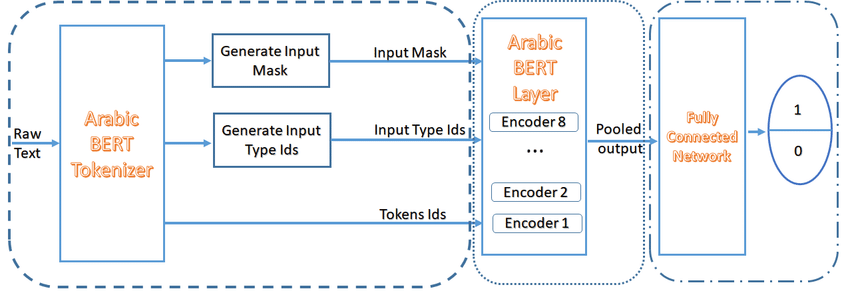

https://huggingface.co/asafaya/bert-base-arabic

- Load the pre-trained AraBERT tokenizer and model

In [ ]:
AraBERT_tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
AraBERT_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")

In [ ]:
def get_embeddings(text):
    tokens = AraBERT_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = AraBERT_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [ ]:
df['arabert_embeddings'] = df['arabic_text'].apply(get_embeddings)

In [ ]:
df

,text,emotion,clean_text,arabic_text,arabert_embeddings
1615,kefaya awe mara wa7da,neutral,kefaya awe mara wa7da,كفاية أو مرة واحدة,"[0.16931398, -0.5546297, -0.3519838, -0.383767..."
1616,ana enbhart w etfg2t awii b7aga zay kda,surprise,ana enbhart w etfg2t awii b7aga zay kda,أنا انبهرت و تفجئة أوي بحاجة زي كدة,"[-0.15406482, -0.046938963, 0.0282835, -0.4709..."
1617,el 7war da kol mftkro o3od ad7ak awiii,happiness,el 7war da kol mftkro o3od ad7ak awiii,إل حوار دى كل مفتقر أعود أضحك أوي,"[0.11048403, -0.8782296, 0.09157974, 0.0200168..."
1618,mt3sbnesh mashy!,angry,mt3sbnesh mashy,متعصبنش ماشي,"[-0.13004471, -0.45024598, -0.25632927, -0.102..."
1619,gatko nela shba kan kwayez b2a w7sh awii,angry,gatko nela shba kan kwayez b2a w7sh awii,جاتك نيلة شبة كان كويز بقى وحش أوي,"[-0.11616512, -0.5175528, -0.08102512, -0.0431..."
...,...,...,...,...,...
2110,eh el araf da ana mt3sab,angry,eh el araf da ana mt3sab,إيه إل عرف دى أنا متعصب,"[-0.043054655, -1.5432172, -0.24546176, -0.031..."
2111,tab law omt w gbthalk..,neutral,tab law omt w gbthalk,Tab Law Omt w gbthalk,"[0.30894408, -0.4868172, -0.45557344, -0.41803..."
2112,ana msh msda2 ana masdoom,surprise,ana msh msda2 ana masdoom,أنا مش مصدق أنا مصدوم,"[-0.19838612, -0.7379825, -0.19112447, -0.4421..."
2113,eh el mofg2at el 8areba de,surprise,eh el mofg2at el 8areba de,إيه إل مفجأة إل ضربة د,"[0.21245086, -0.82397294, -0.21424234, -0.4389..."


- Save the dataset after embedding 

In [ ]:
# after_embedding_df = df.copy()
# after_embedding_df.to_csv('after_embedding_df.csv', index=False)

## c) Step 3: Models Development
+ Split data into 80% train and 20% test
+ Bi-LSTM model devalopment
+ CNN model devalopment

pip install imbalanced-learn

https://en.wikipedia.org/wiki/Conditional_random_field#:~:text=Conditional%20random%20fields%20(CRFs)%20are,can%20take%20context%20into%20account.

In [ ]:
X = df['arabert_embeddings'].astype(str).tolist()
y = df['emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

#train test split 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

Bi-LSTM


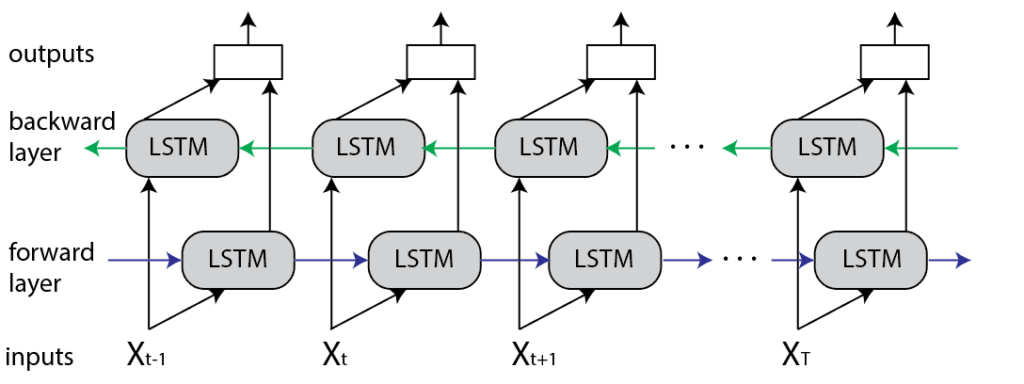

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_lstm.add(Bidirectional(LSTM(64,return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(7, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   

model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm}")

Epoch 1/10
12/12 [==============================] - 74s 5s/step - loss: 1.8484 - accuracy: 0.3778 - val_loss: 1.5790 - val_accuracy: 0.4500
Epoch 2/10
12/12 [==============================] - 53s 4s/step - loss: 1.5922 - accuracy: 0.4056 - val_loss: 1.5823 - val_accuracy: 0.4500
Epoch 3/10
12/12 [==============================] - 53s 4s/step - loss: 1.5794 - accuracy: 0.4056 - val_loss: 1.5694 - val_accuracy: 0.4500
Epoch 4/10
12/12 [==============================] - 55s 5s/step - loss: 1.5450 - accuracy: 0.4056 - val_loss: 1.5787 - val_accuracy: 0.4500
Epoch 5/10
12/12 [==============================] - 58s 5s/step - loss: 1.4913 - accuracy: 0.4056 - val_loss: 1.6139 - val_accuracy: 0.4500
Epoch 6/10
12/12 [==============================] - 57s 5s/step - loss: 1.4962 - accuracy: 0.4056 - val_loss: 1.6286 - val_accuracy: 0.4500
Epoch 7/10
12/12 [==============================] - 54s 4s/step - loss: 1.3172 - accuracy: 0.4639 - val_loss: 1.6067 - val_accuracy: 0.4500
Epoch 8/10
12/12 [==

In [ ]:
print("LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm))

LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        18
           3       0.40      1.00      0.57        40
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         9

    accuracy                           0.40       100
   macro avg       0.07      0.17      0.10       100
weighted avg       0.16      0.40      0.23       100



c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
# Saving the Bi-LSTM model
model_lstm.save("Bi-LSTM_model.h5")

c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

CNN

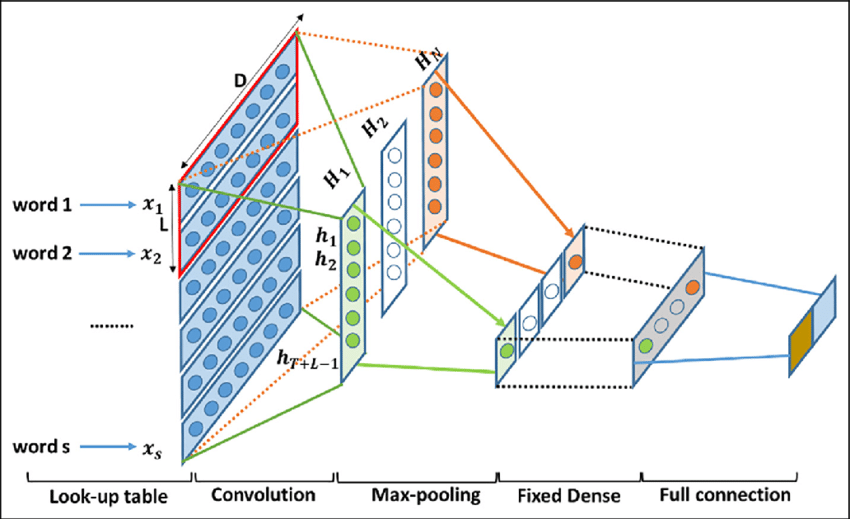

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(7, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

print(f"CNN Model Accuracy: {accuracy_cnn}")
print("CNN Model Classification Report:\n", classification_report(y_test, y_pred_cnn))

Epoch 1/10
12/12 [==============================] - 6s 365ms/step - loss: 1.8645 - accuracy: 0.3139 - val_loss: 1.7218 - val_accuracy: 0.4500
Epoch 2/10
12/12 [==============================] - 4s 316ms/step - loss: 1.6184 - accuracy: 0.4056 - val_loss: 1.5740 - val_accuracy: 0.4500
Epoch 3/10
12/12 [==============================] - 4s 324ms/step - loss: 1.4840 - accuracy: 0.4056 - val_loss: 1.5809 - val_accuracy: 0.4500
Epoch 4/10
12/12 [==============================] - 4s 377ms/step - loss: 1.3735 - accuracy: 0.5444 - val_loss: 1.6025 - val_accuracy: 0.4500
Epoch 5/10
12/12 [==============================] - 4s 335ms/step - loss: 1.2206 - accuracy: 0.6333 - val_loss: 1.6014 - val_accuracy: 0.4500
Epoch 6/10
12/12 [==============================] - 4s 318ms/step - loss: 1.0261 - accuracy: 0.6361 - val_loss: 1.6064 - val_accuracy: 0.4500
Epoch 7/10
12/12 [==============================] - 4s 331ms/step - loss: 0.8027 - accuracy: 0.6861 - val_loss: 1.6746 - val_accuracy: 0.2000
Epoch 

c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [ ]:
#----------------------------------------------------------------
# # Add CRF layer
# model_cnn.add(CRF(5))

# # Compile the model with CRF layer
# model_cnn.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
#----------------------------------------------------------------

## Testing models
+ testing Bi-LSTM
+ testing CNN

In [ ]:
def preprocess_text_for_prediction(text, tokenizer, max_length):
    cleaned_text = clean_text(text)
    translated_text = translate_to_arabic(cleaned_text)
    # Tokenize and pad the text
    text_sequence = tokenizer.texts_to_sequences([translated_text])
    text_padded = pad_sequences(text_sequence, maxlen=max_length)
    return text_padded

In [ ]:
def predict_emotion(model, text_padded):
    predictions = model.predict(text_padded)
    return predictions[0]  # Return the probabilities for each class

In [ ]:
new_text = "hahahahahha eh elgamal da"

new_text_padded = preprocess_text_for_prediction(new_text, tokenizer, X_padded.shape[1])
predicted_probabilities = predict_emotion(model_lstm, new_text_padded)

# Display the predicted emotion and probabilities
predicted_class = np.argmax(predicted_probabilities)
predicted_emotion = label_encoder.classes_[predicted_class]
probabilities_dict = {emotion: round(prob * 100, 2) for emotion, prob in zip(label_encoder.classes_, predicted_probabilities)}
sorted_probabilities = dict(sorted(probabilities_dict.items(), key=lambda item: item[1], reverse=True))

print(f"Predicted Emotion: {predicted_emotion}")
print("Probabilities:")
for emotion, prob in sorted_probabilities.items():
    print(f"{emotion}: {prob}%")

1/1 [==============================] - 0s 384ms/step
Predicted Emotion: happiness
Probabilities:
happiness: 89.37%
neutral: 4.72%
angry: 3.98%
surprise: 1.13%
sadness: 0.43%
fear: 0.38%


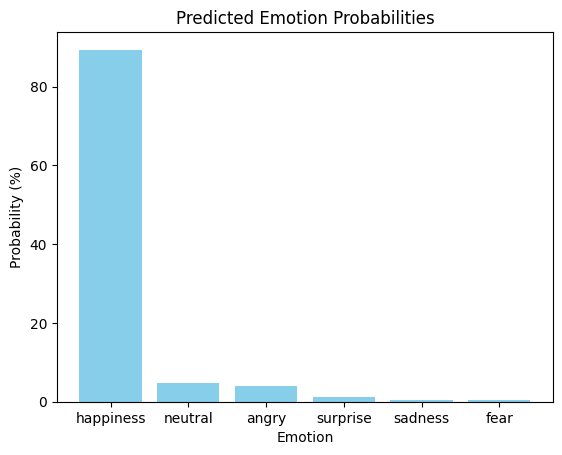

In [ ]:
# Plotting the probabilities
plt.bar(sorted_probabilities.keys(), sorted_probabilities.values(), color='skyblue')
plt.title('Predicted Emotion Probabilities')
plt.xlabel('Emotion')
plt.ylabel('Probability (%)')
plt.show()